# Answering Business Questions with SQL 
<img src='https://www.businessbacker.com/wp-content/uploads/2015/03/questionmark_blog_post_904x400.jpg' />


## Table of Contents
---
- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Business Questions](#Business-Questions)
- [Connecting to the Database](#Connecting-to-the-Database)
    - [Selecting Albums to Purchase](#A.-Selecting-Albums-to-Purchase)
    - [Employee Sales Performance](#B.-Employee-Sales-Performance)
    - [Sales by Country](#C.-Sales-by-Country)
    - [Albums vs Individual Tracks](#D.-Albums-vs-Individual-Tracks)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Introduction
---
As Business Analysts, we have been contacted by a fictional online music store called Chinook. The company wants our help with answering some business questions.

They provided access to their [database](https://github.com/lerocha/chinook-database), which contains information about the artists, songs, and albums from the music store. Employee information, customer information, and the details of purchase transactions can also be found in the database. The entity relationship diagram below provides a structural overview of the Chinook database:

<img src='https://s3.amazonaws.com/dq-content/189/chinook-schema.svg'
     height= '500'
     width='500'/>
     
## Importing Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sqlalchemy import create_engine

# Configure plotting defaults
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')
plt.rcParams.update({'font.family':'Arial'})

## Connecting to the Database
---

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
# The engine helps us use the pandas read_sql function
engine = create_engine('sqlite:///chinook.db')

In [4]:
%%sql
-- Preview the tables in the database
SELECT COUNT(*) OVER(ORDER BY name) AS SN,
       name, 
       type
  FROM sqlite_master
 WHERE type IN ('table', 'view');

 * sqlite:///chinook.db
Done.


SN,name,type
1,album,table
2,artist,table
3,customer,table
4,employee,table
5,genre,table
6,invoice,table
7,invoice_line,table
8,media_type,table
9,playlist,table
10,playlist_track,table


>- The Chinook database contains 11 tables with information about the store's tracks, employees, customers, and purchase transactions.

## Business Questions

### A. Selecting Albums to Purchase
---

#### The Situation
The Chinook record store has just signed a deal with a new record label. They want us to advise on the first three albums they should add to the store from a list of four options. All four albums are by artists with no tracks in their store right now. Here are the names of the artists and the genre of music they produce:


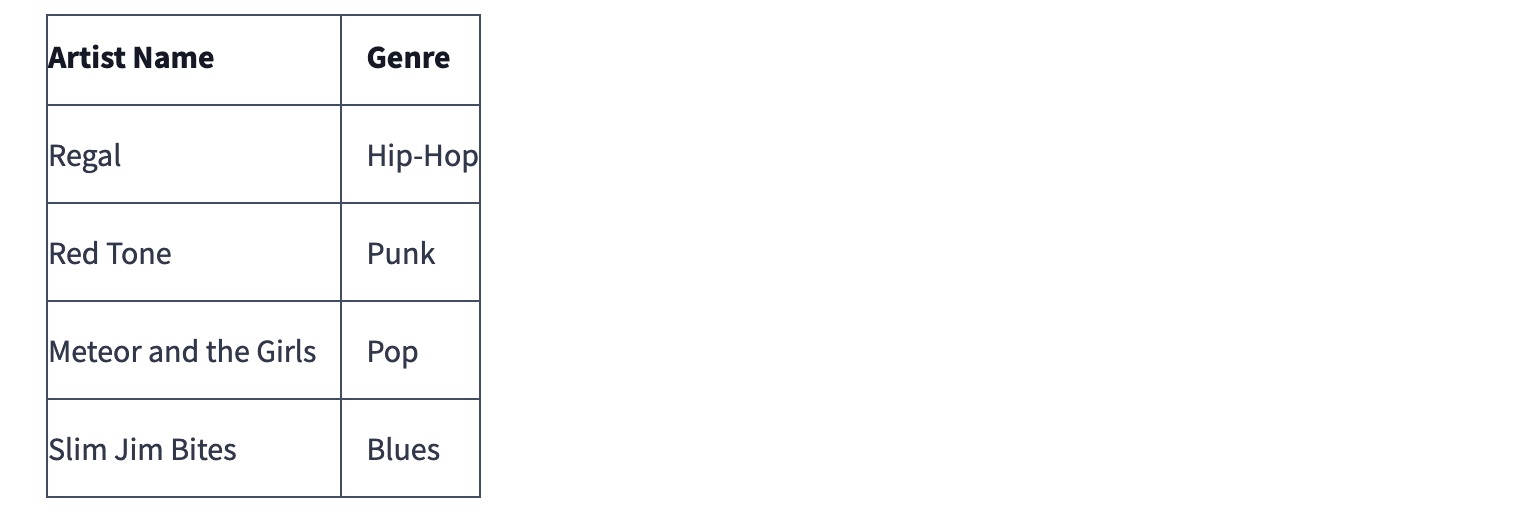

The record label specializes in artists from the USA. Hence, advertisements will target US-based customers. We are interested in finding out which genres sell the best in the USA.

#### Analysis
We can write a query that returns each genre with the proportion of tracks sold in the USA:

In [5]:
query = """
        -- Collect relevant data from the invoice, genre and track tables
        WITH t1 AS (SELECT iv.billing_country,
                           il.quantity, 
                           gr.name as genre_name
                      FROM invoice iv
                      JOIN invoice_line il
                        ON iv.invoice_id = il.invoice_id
                      JOIN track tr
                        ON tr.track_id = il.track_id
                      JOIN genre gr
                        ON gr.genre_id = tr.genre_id
                     WHERE iv.billing_country = 'USA'
                   ),

        -- Compute the number of purchases per genre
              t2 AS (SELECT genre_name,
                            COUNT(*) AS num_purchases
                       FROM t1
                      GROUP BY 1
                      ORDER BY 2 DESC
                    ) 

        -- Compute the percentage of purchases per genre
        SELECT *, 
                ROUND(num_purchases * 100 / 
                      CAST(
                           (SELECT SUM(num_purchases) FROM t2) 
                            AS Float
                          ), 1
                     ) AS percentage_sold
          FROM t2;
        """
# Read query into a pandas dataframe
df = pd.read_sql(query, engine)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Pop,22,2.1
7,Latin,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


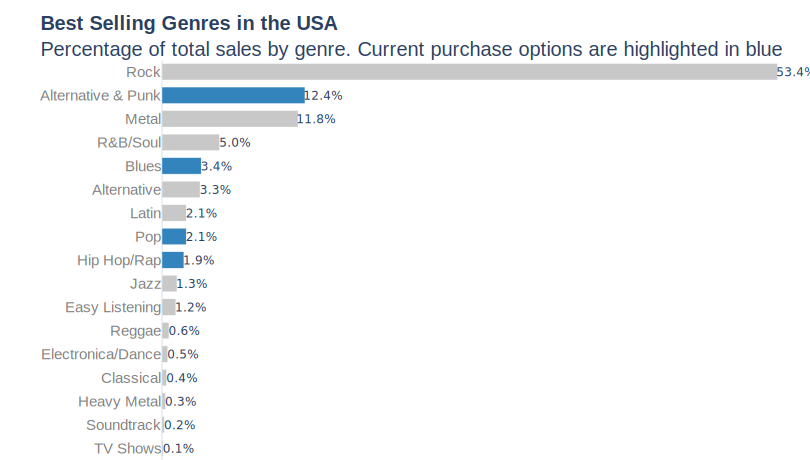

In [6]:
df = df.sort_values(by='percentage_sold')

# Create a color map to identify key albums of interest
album_options = ['Hip Hop/Rap', 'Alternative & Punk', 'Blues', 'Pop']
cmap = df['genre_name'].apply(lambda x: x in album_options)

fig = px.bar(df, 
             y = 'genre_name', 
             x = 'percentage_sold',  
             width = 810, 
             height = 460, 
             orientation = 'h')

fig.update_traces(text = [f'{val}\u0025' for val in df['percentage_sold']],
                  width = 0.7, 
                  textposition = 'outside', 
                  textfont = dict(family='trebuchet MS',size=12),
                  # Color bars based on defined color map
                  marker = dict(
                      color = cmap.astype(int), 
                      colorscale = [[0, '#BABABA'], [1, '#0064AB']],
                      opacity = 0.8)
                 )

fig.update_xaxes(showgrid = False, showticklabels = False)

fig.update_yaxes(tickfont_color='grey', ticksuffix = '   ', tickfont = dict(size=15))

fig.update_layout(template = 'plotly_white', 
                  font_family = 'Arial',
                  xaxis_title = None, 
                  yaxis_title = '',
                  title = '<b>Best Selling Genres in the USA</b><br>'+
                  'Percentage of total sales by genre. Current purchase options are highlighted in blue',
                  titlefont_size = 20,
                  margin = dict(b=0, r=0))

fig.show('svg')

#### Results
>Based on the genre sales pattern in the USA. Chinook should select these options from the list of available albums.
>- **Punk:** Red Tone
>- **Blues:** Slim Jim Bites 
>- **Pop:** Meteor and the Girls
  
>It's worth noting that these three genres only make up **17%** of total sales. To maximize profitability, the company should be on the lookout for Rock songs since they account for **53%** of sales in the US market.
  
### B. Employee Sales Performance
---
#### The Situation
After an initial purchase, each Chinook customer is assigned to a sales support agent. The company asked us to analyze purchases from customers belonging to each sales agent. They want to know if some agents are performing better or worse than others.

#### Analysis
To answer this question, we need to extract the names of the sales executives, their hire dates, the number of accounts they handle, and the total purchases made by these accounts. We will also compute the average sales for each account that the sales executives manage.

In [7]:
query = """
        WITH t1 AS (SELECT em.first_name || ' ' || em.last_name AS sales_rep_name,
                           em.hire_date,
                           COUNT(cu.customer_id) AS num_customers,
                           CAST(SUM(iv.total) AS Integer) AS total_sales
                      FROM employee em
                      JOIN customer cu
                        ON em.employee_id = cu.support_rep_id
                      JOIN invoice iv
                        ON iv.customer_id = cu.customer_id
                     GROUP BY 1
                     ORDER BY 4 DESC)

        SELECT *, 
               ROUND(CAST(total_sales AS Float) / num_customers, 2)
                 AS sales_per_customer         
          FROM t1;
       """

df = pd.read_sql(query, engine)
df

,sales_rep_name,hire_date,num_customers,total_sales,sales_per_customer
0,Jane Peacock,2017-04-01 00:00:00,212,1731,8.17
1,Margaret Park,2017-05-03 00:00:00,214,1584,7.40
2,Steve Johnson,2017-10-17 00:00:00,188,1393,7.41


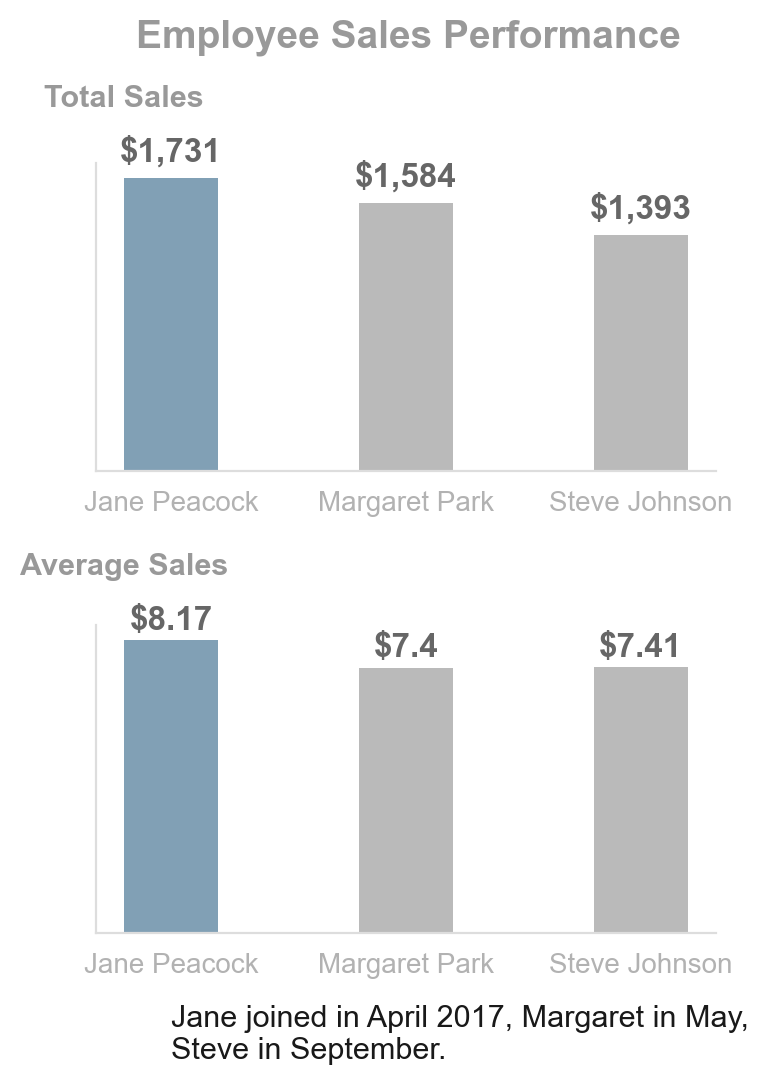

In [8]:
fig = plt.figure(figsize=(4, 5))

# Total sales chart
plt.subplot(2, 1, 1)
plt.bar(data=df, x='sales_rep_name', height='total_sales', width=0.4, color='#BABABA')
plt.bar(data=df.query('sales_rep_name=="Jane Peacock"'), alpha=0.3,
         x='sales_rep_name', height='total_sales', width=0.4, color='#0064AB')

# Sales chart label
plt.text(x=-0.2, y=2150, s='Total Sales', size=11, fontweight='bold', alpha=0.4, ha='center')

# Total sales annotations
for sales, index in zip(df.total_sales, range(3)):
    plt.text(x=index, y=sales+100, s= '${:,}'.format(sales), ha='center', 
             fontweight='bold', alpha=0.6, size=12)

# Main chart title
plt.text(x=-0.15, y=2500, s='Employee Sales Performance', size=14, alpha=0.4, fontweight='bold')

# Average sales chart
plt.subplot(2, 1, 2)
plt.bar(data=df, x='sales_rep_name', height='sales_per_customer', width=0.4, color='#BABABA')
plt.bar(data=df.query('sales_rep_name=="Jane Peacock"'), alpha=0.3,
        x='sales_rep_name', height='sales_per_customer', width=0.4, color='#0064AB')

# Average sales chart label
plt.text(x=-0.2, y=10, s='Average Sales', size=11, fontweight='bold', alpha=0.4, ha='center')

# Average sales annotations
for sales, index in zip(df.sales_per_customer, range(3)):
    plt.text(x=index, y=sales+0.3, s= '${:,}'.format(sales), ha='center', 
             fontweight='bold', alpha=0.6, size=12)

# Footnote
plt.text(x=0, y=-3.5, s='Jane joined in April 2017, Margaret in May,\nSteve in September.', 
         size=11, alpha=0.9)

# Common attributes to both charts
for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine()
    ax.tick_params(left=False, bottom=False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('#DDD')
    plt.xticks(size=10, alpha=0.3)
    plt.yticks([])
    
plt.subplots_adjust(hspace=0.5)

#### Results
>- Of the three sales employees, Jane achieved the highest total sales of **1,731 dollars**. Margaret Park comes second, and Steve occupies the
last place with **1,393 dollars** in sales. This difference in sales is understandable, considering that Jane and Margaret were
employed about **five** months before Steve. 
>- Jane's average sales numbers support her leading position. She has achieved **8.17 dollars** in sales per customer, the highest of the three employees. Steve also performs marginally better than Margaret despite the difference in their employment dates.

### C. Sales by Country
---
#### The Situation
Chinook wants to understand how sales are distributed across different countries. The company intends to identify countries with growth potential and may even run advertising campaigns in these countries.

#### Analysis
To answer this question, we will write a query that collates data on purchases from different countries. For each country, we will include the total number of customers, total sales value, average sales per customer, and the average order value. Where a country has only one customer, we will collect it into an "Other" group:

In [9]:
query = """
        -- Collate the number of customers in each country
        WITH t1 AS( SELECT country, COUNT(customer_id) AS num_customers
                      FROM customer
                     GROUP BY country
                  ),
                  
        -- Collate the total sales in each country
             t2 AS( SELECT cu.country,
                           ROUND(SUM(iv.total), 2) AS total_sales,
                           COUNT(iv.invoice_id) AS num_sales
                      FROM customer cu
                      JOIN invoice iv
                        ON cu.customer_id = iv.customer_id
                     GROUP BY 1
                   ),
                   
        -- Group countries with only one customer as 'Others'
             t3 AS( SELECT CASE WHEN t1.num_customers = 1 THEN 'Others'
                                ELSE t1.country END AS countries, 
                           SUM(t1.num_customers) AS num_customers,
                           SUM(t2.total_sales) AS total_sales,
                           SUM(t2.num_sales) AS num_sales
                      FROM t1
                      JOIN t2
                        ON t1.country = t2.country
                     GROUP BY 1
                  )

        -- Calculate relevant sales metrics
        SELECT countries, 
               num_customers, 
               total_sales,
               ROUND(total_sales / num_sales, 2) AS avg_order_value,
               ROUND(total_sales / num_customers, 2) AS sales_per_customer
          FROM (
                 SELECT *, 
                    CASE WHEN countries = 'Others' THEN 1
                             ELSE 0 END AS sort
                   FROM t3
               )
          ORDER BY sort, num_customers DESC;
        """
df = pd.read_sql(query, engine)
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,United Kingdom,3,245.52,8.77,81.84
6,Czech Republic,2,273.24,9.11,136.62
7,India,2,183.15,8.72,91.58
8,Portugal,2,185.13,6.38,92.57
9,Others,15,1094.94,7.45,73.00


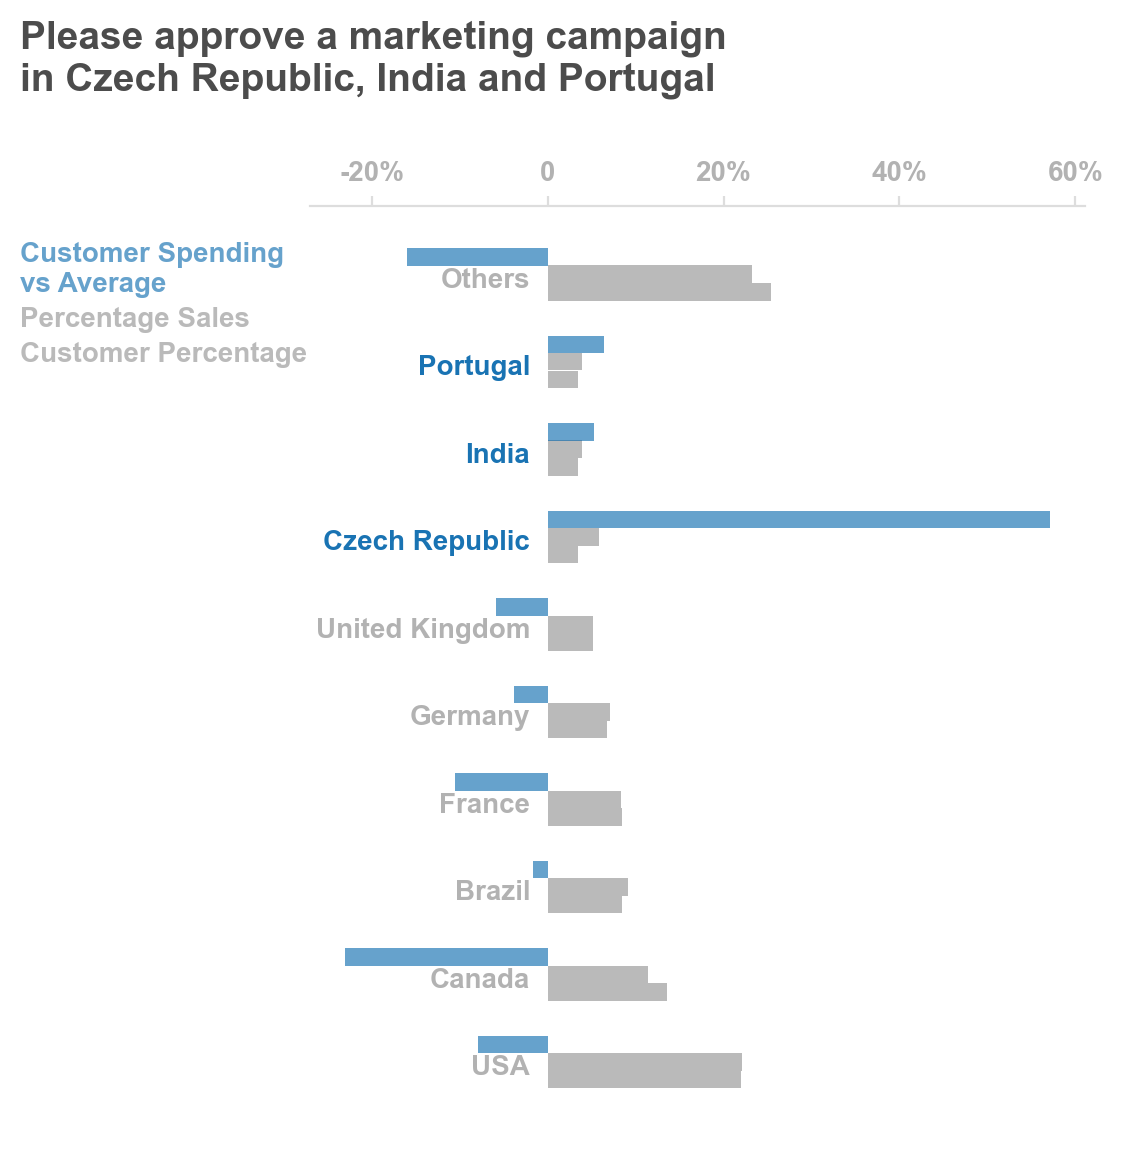

In [10]:
# Additional calculations
avg_cust_purchase = df.sales_per_customer.mean()
df['pcent_customer'] = round(100*df.num_customers / df.num_customers.sum(), 1)
df['pcent_sales'] = round(100*df.total_sales / df.total_sales.sum(), 1)
df['cust_purchase_diff'] = round(100 * (df.sales_per_customer - avg_cust_purchase) / 
                                 avg_cust_purchase, 2)

# Visualization
y_labs = df.countries.values
y_axes = np.arange(df.countries.size)

fig = plt.figure(figsize=(5, 6))
plt.barh(y_axes-0.3, df.pcent_customer, height=0.2, color='#BABABA')
plt.barh(y_axes-0.1, df.pcent_sales, height=0.2, color='#BABABA')
plt.barh(y_axes+0.1, df.cust_purchase_diff, height=0.2, color='#0064AB', alpha=0.6)

color_map = ['', '', '', '', '', '', 'Yes', 'Yes', 'Yes', '']

# Annotate y axis ticks
for loc, label, color in zip(y_axes, y_labs, color_map):
    if color == 'Yes':
        plt.text(x=-2, y=loc-0.25, s=label, ha='right', color = '#0064AB',
                 alpha=0.9, size=10, fontweight='bold')
    else:
        plt.text(x=-2, y=loc-0.25, s=label, ha='right', size=10, alpha=0.3, fontweight='bold')

# Set plot legend
plt.text(x=-60, y=8.7, s='Customer Spending\nvs Average', color='#0064AB', 
         size=10, alpha=0.6, fontweight='bold')
plt.text(x=-60, y=8.3, s='Percentage Sales', color='#BABABA', size=10, fontweight='bold')
plt.text(x=-60, y=7.9, s='Customer Percentage', color='#BABABA', size=10, fontweight='bold')

# Set plot title
plt.text(x=-60, y=11, s='Please approve a marketing campaign\n'+
        'in Czech Republic, India and Portugal', alpha=0.7, 
         size=14, fontweight='bold')

for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True, bottom=True, top=False)
    ax.tick_params(left=False, bottom=False, color='#ddd')
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_color('#DDD')
    plt.yticks([])
    plt.xticks([-20, 0, 20, 40, 60], ['-20%', '0', '20%', '40%', '60%'],
               size=10, alpha=0.3, fontweight='bold')

#### Results
>- The Majority of Chinook sales arise from **US** and **Canada**. These two countries dominate in customer base as well as sales. However, customers spend lesser per invoice in these countries. 
>- Although the **Czech Republic, Portugal, and India** record fewer customers and lesser sales values,  customers spend more per invoice than in other countries. To increase revenue from these three markets, Chinook could run marketing campaigns to expand its customer base.
   
Since the data from each country are relatively few, the initial marketing campaigns should be small. They should aim to collect and analyze customer data so that the right trends are confidently identified.

### D. Albums vs Individual Tracks
---
 
#### The Situation
Chinook organizes its store to allow purchases in one of two ways. Customers can purchase a whole album or a collection of one or more individual tracks.

The store does not let customers purchase a whole album and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers buy albums, they are charged the same price as if they had purchased each of those tracks separately. 

Chinook is considering changing its purchasing strategy to save money. The company wants to purchase only the most popular tracks from record companies instead of buying every track from an album. We have been asked to determine what percentage of Chinook's sales are individual tracks vs. whole albums. Management can use this data to understand the effect of their decision on overall revenue.

#### Analysis
We have two edge cases to consider:
>- Albums with only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
>- Customers may decide to select every track from an album manually and then add a few individual tracks from other albums to their purchase.
  
Since our analysis is concerned with maximizing revenue, we can safely ignore albums consisting of only a few tracks. The company has previously investigated to confirm that the second case does not often happen; we can overlook this case also.

To answer the question, we will identify whether each invoice has all the tracks from an album:

In [11]:
%%sql
-- Collate the list of invoices and their albums
WITH t1 AS(SELECT invoice_id,
                  album_id
             FROM invoice_line
             JOIN track
            USING(track_id)
             LEFT JOIN album
            USING(album_id)
            GROUP BY 1
          ),

-- Check if all tracks in an invoice belong to an album
      t2 AS(SELECT CASE WHEN
                             (SELECT track_id
                                FROM invoice_line il
                               WHERE t1.invoice_id = il.invoice_id
                              EXCEPT
                              SELECT track_id
                                FROM track
                               WHERE track.album_id = t1.album_id
                             ) IS NULL
                        AND
                             (SELECT track_id
                                FROM track
                               WHERE track.album_id = t1.album_id
                              EXCEPT
                              SELECT track_id
                                FROM invoice_line il
                               WHERE t1.invoice_id = il.invoice_id
                             ) IS NULL
                        THEN 'Yes' 
                        ELSE 'No' 
                        END AS album_purchase
               
              FROM t1
          )
    
-- Collate album purchase frequencies          
SELECT album_purchase, 
       COUNT(1) AS num_invoices,
       ROUND(
             CAST(COUNT(1) * 100 AS Float) / (SELECT COUNT(1) FROM t2)
            , 1) AS percentage
  FROM t2
 GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,num_invoices,percentage
No,500,81.4
Yes,114,18.6


#### Results
> Most purchases (81%) from the store are individual tracks. However, in about 19% of cases, customers buy entire albums. Chinook should be careful with purchasing only the most popular tracks since it risks losing revenue from customers who purchase entire albums.

## Conclusion and Recommendations
---
During this project, we helped a fictional company address questions that may help improve profitability. We can advise on aspects of the company's business from various situations presented.

- Regarding the new record label, the company should make the best out of genres with high popularity in the US. They should select Hip-Hop, Punk, and Pop from the current options. Chinook should also be on the lookout for Rock songs since they account for the USA's most significant sales (53%).

- Jane Peacock is Chinook's best-performing salesperson. Steve Johnson appears to be underperforming in total sales, but this is only because he joined four months later than the others.

- US and Canada have the most extensive customer base, but customers spend less per transaction. The Czech Republic, India, and Portugal have the highest spending customers. Chinook could launch a marketing campaign to increase the customer base in the three regions.

- The plan to focus only on popular tracks may sound viable. However, it risks losing revenue from customers who prefer entire albums. It is better to conduct surveys and gather customer perspectives before implementing any new plan.
